<a href="https://colab.research.google.com/github/JonahFlateman/dsc-project-template/blob/master/mod4_project-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing and inspecting the ratings DataFrame.

In [1]:
import numpy as np

In [2]:
import pandas as pd
df = pd.read_csv('/content/ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Having a quick look at a barplot of user ratings and value counts.

In [4]:
rating_counts = df['rating'].value_counts()
sorted_counts = {k:v for k, v in sorted(rating_counts.items(), key=lambda x: x[1])}
sorted_count = list(sorted_counts.items())
x = [item[0] for item in sorted_count]
y = [item[1] for item in sorted_count]

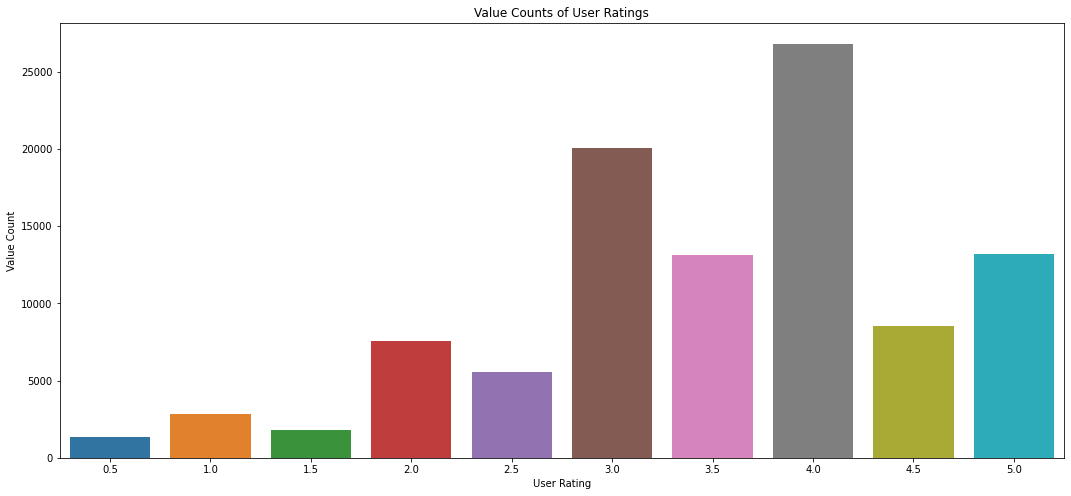

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(18,8))
sns.barplot(x=x, y=y)
plt.title('Value Counts of User Ratings')
plt.xlabel('User Rating')
plt.ylabel('Value Count')
plt.show()

Most ratings are 3, 4, or 5.  Is scaling from 0-5 the best use for this data?  Further down the line we may want to experiment with this.

In [6]:
df_movies = pd.read_csv('/content/movies.csv')

In [7]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Which genres have the best ratings?  Let's merge these two DataFrames and inspect.

In [8]:
#Using MovieId column to merge DataFrames
df_merged = pd.merge(df_movies,df, on=['movieId'])

In [9]:
#Splitting genre column to list of genres
df_merged['genres'] = df_merged['genres'].apply(lambda x: x.split("|") if x else x)
df_merged.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,964982703
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,847434962
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,1106635946
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,1510577970
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,1305696483


In [10]:
#Creating a set of all genres in genre column
all_genres = set()
for genres in df_merged['genres']:
    if genres:
        all_genres.update(genres)

In [11]:
#Adding genre columns to DataFrame
for genre in all_genres:
    df_merged[genre] = np.zeros(shape=df_merged.shape[0])

In [12]:
#Iterate through the movies and update the genre columns to 1 if the movie contains that genre
#This cell takes a few minutes to run
for index, row in df_merged.iterrows():
    if row['genres']:
        for genre in row['genres']:
            df_merged.loc[index, genre] = 1
df_merged.head()

,movieId,title,genres,userId,rating,timestamp,Animation,Film-Noir,Crime,Western,Fantasy,War,Drama,(no genres listed),Horror,Sci-Fi,Musical,Comedy,Documentary,Thriller,IMAX,Adventure,Romance,Mystery,Action,Children
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,964982703,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,847434962,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,1106635946,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,1510577970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,1305696483,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [13]:
#Getting means of genre ratings in list
genre_rating = []
genres = []
for genre in all_genres:
    genres.append(genre)
    genre_rating.append(df_merged.loc[df_merged[genre]==1, ['rating']].mean())

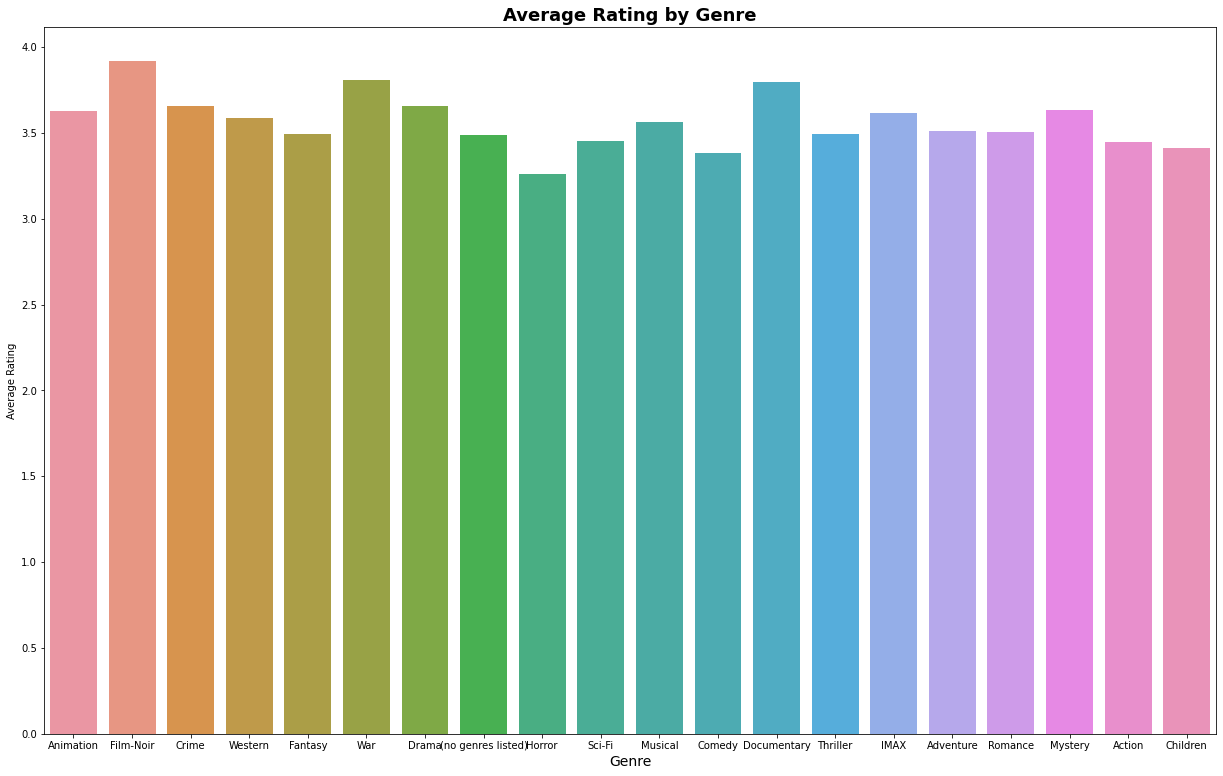

In [14]:
plt.figure(figsize=(21,13))
sns.barplot(x=genres, y=[i[0] for i in genre_rating])
plt.title('Average Rating by Genre', fontweight='bold', fontsize=18)
plt.xlabel('Genre',fontsize=14)
plt.ylabel('Average Rating')
plt.show()

War, Documentary, and Film-Noir rank highest.

In [15]:
# Drop unnecessary columns
new_df = df.drop(columns='timestamp')

Using Reader and Dataset classes to transform dataset for surprise compatability.

In [16]:
!pip install surprise
from surprise import Reader, Dataset
# read in values as Surprise dataset
reader = Reader()
data = Dataset.load_from_df(new_df, reader)

     |████████████████████████████████| 11.8 MB 47 kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617788 sha256=57ab94c02e3e5364012e39973e9b76927d886adc529550980da4fd9f80a9b7dd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [17]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


Determine the best model.

In [18]:
# importing relevant libraries
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

In [19]:
## Perform a gridsearch with SVD
# ⏰ This cell may take several minutes to run
params = {'n_factors': [25, 50, 100],
         'reg_all': [.02, .05, .1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

In [20]:
# print out optimal parameters for SVD after GridSearch
g_s_svd.best_params

{'mae': {'n_factors': 100, 'reg_all': 0.05},
 'rmse': {'n_factors': 100, 'reg_all': 0.05}}

In [21]:
g_s_svd.best_score

{'mae': 0.6679276189836594, 'rmse': 0.8685226023886969}

In [22]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options ={'name': 'pearson', 'user_based': True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [23]:
for i in cv_knn_basic.items():
    print(i)

('test_rmse', array([0.96315591, 0.97456776, 0.9767654 , 0.97187361, 0.96855725]))
('test_mae', array([0.74407057, 0.75171266, 0.75602012, 0.74925462, 0.74750939]))
('fit_time', (0.7391948699951172, 0.8526341915130615, 0.7333786487579346, 0.8392772674560547, 0.5059711933135986))
('test_time', (2.507439613342285, 2.4715590476989746, 2.5027225017547607, 2.4012937545776367, 1.2857418060302734))


In [24]:
# print out the average RMSE score for the test set
print(np.mean(cv_knn_basic['test_rmse']))

0.9709839832931051


In [25]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options ={'name': 'pearson', 'user_based': True})
cv_knn_baseline = cross_validate(knn_baseline, data, n_jobs=-1)

In [26]:
# print out the average score for the test set
for i in cv_knn_baseline.items():
    print(i)

('test_rmse', array([0.88038337, 0.88499604, 0.87220957, 0.87597846, 0.87673895]))
('test_mae', array([0.67151441, 0.67776918, 0.66521842, 0.66800174, 0.66838228]))
('fit_time', (0.8878858089447021, 1.2025980949401855, 1.191166877746582, 1.3195016384124756, 0.86956787109375))
('test_time', (3.804966688156128, 3.8045554161071777, 3.9537458419799805, 3.455230712890625, 1.9107458591461182))


In [27]:
print(np.mean(cv_knn_baseline['test_rmse']))

0.8780612770099092


The best model is SVD with n_factors=25 and regularization rate of 0.05.



Let's make recommendations using movie titles.

In [28]:
svd = SVD(n_factors=25, reg_all=0.05)
svd.fit(dataset)

In [29]:
svd.predict(3, 6)

Prediction(uid=3, iid=6, r_ui=None, est=2.977520642735509, details={'was_impossible': False})

In [30]:
def movie_rater(movie_df,num, genre=None):
    # Establish UserID
    userID = 1000
    # Create empty rating_list which will be a collection of dictionaries with format:
        #{'userId': int , 'movieId': int , 'rating': float}
    rating_list = []
    #Use while loop to prompt user to input rating for sample movie, "n" will skip if user has not seen it
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie['title'])
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list

In [31]:
user_rating = movie_rater(df_movies, 5)

1089    Mother (1996)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
6692    College Road Trip (2008)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
3620    Blue Angel, The (Blaue Engel, Der) (1930)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2
4858    Barbershop 2: Back in Business (2004)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
7103    Time Traveler's Wife, The (2009)
Name: title, dtype: object
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3


In [32]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = new_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [33]:
# train a model using the new combined DataFrame
svd = SVD(n_factors=25, reg_all=0.05)
svd.fit(new_data.build_full_trainset())

In [34]:
# make predictions for the user
list_of_movies = []
for m_id in new_df['movieId'].unique():
    list_of_movies.append((m_id, svd.predict(1000, m_id)[3]))

In [35]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x: x[1], reverse=True)

In [36]:
# return the top n recommendations
def recommended_movies(user_ratings,movie_title_df,n):
    # Iterate through user_ratings to pull title
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation #', idx+1, ': ', title, '\n')
        n -=1
        if n == 0:
            break
            
recommended_movies(ranked_movies,df_movies,5)

Recommendation # 1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation # 2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation # 3 :  883    Paths of Glory (1957)
Name: title, dtype: object 

Recommendation # 4 :  686    Rear Window (1954)
Name: title, dtype: object 

Recommendation # 5 :  659    Godfather, The (1972)
Name: title, dtype: object 



Next we will see if we can get a better RMSE using ALS in PySpark.

In [37]:

!apt update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [38]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark

In [39]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

In [40]:
import findspark
findspark.init()

In [41]:
import pyspark
sc = pyspark.SparkContext('local[*]')

In [42]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession

# instantiate SparkSession object
spark = SparkSession.builder.master("local").getOrCreate()

In [43]:
# read in the dataset into pyspark DataFrame
movie_ratings = spark.read.csv('/content/ratings.csv', header='true', inferSchema='true')

Below we will define a function to calculate the sparsity of the DataFrame.

In [44]:
def get_mat_sparsity(ratings):
    # Count the total number of ratings in the dataset
    count_nonzero = ratings.select("rating").count()

    # Count the number of distinct userIds and distinct movieIds
    total_elements = ratings.select("userId").distinct().count() * ratings.select("movieId").distinct().count()

    # Divide the numerator by the denominator
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings DataFrame is ", "%.2f" % sparsity + "% sparse.")
    
get_mat_sparsity(movie_ratings)

The ratings DataFrame is  98.30% sparse.


In [45]:
# Group data by userId, count ratings
userId_ratings = movie_ratings.groupBy("userId").count().orderBy('count', ascending=False)
userId_ratings.show()

+------+-----+
|userId|count|
+------+-----+
|   414| 2698|
|   599| 2478|
|   474| 2108|
|   448| 1864|
|   274| 1346|
|   610| 1302|
|    68| 1260|
|   380| 1218|
|   606| 1115|
|   288| 1055|
|   249| 1046|
|   387| 1027|
|   182|  977|
|   307|  975|
|   603|  943|
|   298|  939|
|   177|  904|
|   318|  879|
|   232|  862|
|   480|  836|
+------+-----+
only showing top 20 rows



In [46]:
# Group data by userId, count ratings
movieId_ratings = movie_ratings.groupBy("movieId").count().orderBy('count', ascending=False)
movieId_ratings.show()

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
|    260|  251|
|    480|  238|
|    110|  237|
|    589|  224|
|    527|  220|
|   2959|  218|
|      1|  215|
|   1196|  211|
|     50|  204|
|   2858|  204|
|     47|  203|
|    780|  202|
|    150|  201|
|   1198|  200|
|   4993|  198|
+-------+-----+
only showing top 20 rows



In [47]:
movie_ratings.dtypes

[('userId', 'int'),
 ('movieId', 'int'),
 ('rating', 'double'),
 ('timestamp', 'int')]

In [48]:
movie_ratings = movie_ratings.drop('timestamp')

In [49]:
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.recommendation import ALS 

# split into training and testing sets
(training, test) = movie_ratings.randomSplit([.8, .2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')

# fit the ALS model to the training set
model=als.fit(training)

In [50]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(rmse)

0.9793955448233842


In [51]:
predictions.show()

+------+-------+------+------------+
|userId|movieId|rating|  prediction|
+------+-------+------+------------+
|   474|    471|   3.0|   3.2795112|
|    57|    471|   3.0|   3.4281807|
|   610|    471|   4.0|   3.3554935|
|   520|    471|   5.0|   3.8476524|
|   448|    471|   4.0|    3.549129|
|   216|    471|   3.0|    3.948055|
|   287|    471|   4.5|   2.6519618|
|   426|    471|   5.0|    4.357235|
|   599|    833|   1.5|   0.8472545|
|   307|    833|   1.0|-0.019661427|
|   606|   1088|   3.0|   3.2653165|
|   599|   1088|   2.5|   2.9381216|
|   594|   1088|   4.5|   4.3733845|
|   509|   1088|   3.0|   2.9012792|
|    10|   1088|   3.0|   2.6037462|
|   221|   1088|   3.0|   3.1222792|
|   200|   1088|   4.0|   4.1620703|
|   116|   1088|   4.5|   3.3386579|
|   517|   1088|   1.0|    3.677531|
|   385|   1238|   3.0|   3.9354782|
+------+-------+------+------------+
only showing top 20 rows



In [52]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# initialize the ALS model
#als_model = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid              
#params = ParamGridBuilder().addGrid(als_model.regParam, [.01, .05, .1, .15]).addGrid(als_model.rank, [10, 50, 100, 150]).build()

# instantiating crossvalidator estimator
#cv = CrossValidator(estimator=als_model, estimatorParamMaps=params, evaluator=evaluator, parallelism=4)
#best_model = cv.fit(movie_ratings)

In [53]:
#model = best_model.bestModel

In [54]:

# Print best_model
#print(type(model))

# Complete the code below to extract the ALS model parameters
#print("**Best Model**")

# # Print "Rank"
#print("  Rank:", model._java_obj.parent().getRank())

# Print "MaxIter"
#print("  MaxIter:", model._java_obj.parent().getMaxIter())

# Print "RegParam"
#print("  RegParam:", model._java_obj.parent().getRegParam())

Note: The above CV takes 40 minutes to run and yields:
Rank: 50
MaxIter: 10
RegParam: 0.15

In [55]:
final_als = ALS(maxIter=10, rank=50, regParam=0.15, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
final_model = final_als.fit(training)

In [56]:
test_predictions = final_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8744603448628496


In [57]:
test_predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   474|    471|   3.0|  3.092484|
|    57|    471|   3.0| 3.4095232|
|   610|    471|   4.0|  3.323009|
|   520|    471|   5.0| 3.3250353|
|   448|    471|   4.0| 3.1919277|
|   216|    471|   3.0| 3.1740468|
|   287|    471|   4.5| 2.6062477|
|   426|    471|   5.0|  3.131059|
|   599|    833|   1.5| 1.3846078|
|   307|    833|   1.0|  1.355217|
|   606|   1088|   3.0| 3.3293993|
|   599|   1088|   2.5|  2.424682|
|   594|   1088|   4.5| 4.2729383|
|   509|   1088|   3.0| 3.0788243|
|    10|   1088|   3.0| 3.0902216|
|   221|   1088|   3.0| 3.1281378|
|   200|   1088|   4.0| 3.5761337|
|   116|   1088|   4.5| 3.6548903|
|   517|   1088|   1.0| 2.6795106|
|   385|   1238|   3.0|  3.831832|
+------+-------+------+----------+
only showing top 20 rows



In [58]:
movie_titles = spark.read.csv('movies.csv', header='true', inferSchema='true')

movie_titles.head(5)

[Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'),
 Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'),
 Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]

In [59]:
def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [136]:
print(name_retriever(1022, movie_titles))

Cinderella (1950)


In [61]:
users = movie_ratings.select(als.getUserCol()).distinct().limit(1)
userSubsetRecs = model.recommendForUserSubset(users, 10)
recs = userSubsetRecs.take(1)

In [62]:
# use indexing to obtain the movie id of top predicted rated item
first_recommendation = recs[0]['recommendations'][0][0]

# use the name retriever function to get the values
name_retriever(first_recommendation,movie_titles)

'Titanic (1953)'

In [63]:
recommendations = model.recommendForAllUsers(5)
recommendations.where(recommendations.userId == 3).collect()

[Row(userId=3, recommendations=[Row(movieId=3837, rating=10.311745643615723), Row(movieId=158783, rating=9.546235084533691), Row(movieId=27728, rating=9.028257369995117), Row(movieId=5485, rating=8.007699966430664), Row(movieId=80126, rating=7.799057483673096)])]

In [64]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
  new_user_ratings = spark.createDataFrame(new_ratings, rating_df.columns)
    
    # combine the new ratings df with the rating_df
  movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # create an ALS model and fit it
  als = ALS(maxIter=10, rank=50, regParam=0.15, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
  model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
  recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
  recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)

  for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
    movie_string = name_retriever(movie_id, movie_title_df)
    print('Recommendation {}: {} | predicted score: {}'.format(ranking+1, movie_string, rating))

In [65]:
# try out your function with the movies listed above
user_id = 400
user_ratings_1 = [(user_id, 3000, 5), (user_id, 2500, 5), (user_id, 2000, 4), (user_id, 1757, 4)]
new_user_recs(user_id, user_ratings_1, movie_ratings, movie_titles, 10)

Recommendation 1: On the Beach (1959) | predicted score: 5.6094651222229
Recommendation 2: Jetée, La (1962) | predicted score: 5.285323619842529
Recommendation 3: Come and See (Idi i smotri) (1985) | predicted score: 5.279440402984619
Recommendation 4: Saving Face (2004) | predicted score: 5.272751331329346
Recommendation 5: Seve (2014) | predicted score: 5.141029357910156
Recommendation 6: The Big Bus (1976) | predicted score: 5.141029357910156
Recommendation 7: Cosmos | predicted score: 5.136869430541992
Recommendation 8: Crossing Delancey (1988) | predicted score: 5.063690662384033
Recommendation 9: Lady Jane (1986) | predicted score: 5.063690662384033
Recommendation 10: Rivers and Tides (2001) | predicted score: 5.055665493011475


In [320]:
input_samples = movie_ratings.sample(False, 0.001, seed=1000).collect()
sample_list = [i[1] for i in input_samples]
user_id = 1000
rating_list = []
num = 5
for i in range(len(sample_list)):
  print(name_retriever(sample_list[i], movie_titles))
  rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
  if rating == 'n':
    continue
  else:
    rating_list.append((user_id, sample_list[i], int(rating)))
    num -= 1
    if num == 0:
      break

Departed, The (2006)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
12 Angry Men (1957)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
Aladdin (1992)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
5
Real Genius (1985)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
What Lies Beneath (2000)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
National Treasure (2004)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
2


In [318]:
user_id = 1000
rating_list = []
num = 5
for i in range(len(sample_list)):
  print(name_retriever(sample_list[i], movie_titles))
  rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
  if rating == 'n':
    continue
  else:
    rating_list.append((user_id, sample_list[i], int(rating)))
    num -= 1
    if num == 0:
      break

Departed, The (2006)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
12 Angry Men (1957)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
Aladdin (1992)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
Real Genius (1985)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
What Lies Beneath (2000)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
National Treasure (2004)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
Fierce Creatures (1997)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
Beverly Hills Cop (1984)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
Jungle Book, The (1994)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
3
Shawshank Redemption, The (1994)
How do you rate this movie on a scale of 1-5, press n if y

In [327]:
def new_user_recs(user_id, rating_df, movie_title_df, num_ratings, num_recs):

  input_samples = rating_df.sample(False, 0.001, seed=1000).collect()
  sample_list = [i[1] for i in input_samples]
  #user_id = 1000
  new_ratings = []
  #num = 5
  for i in range(len(sample_list)):
    print(name_retriever(sample_list[i], movie_title_df))
    rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
    if rating == 'n':
      continue
    else:
      new_ratings.append((user_id, sample_list[i], int(rating)))
      num_ratings -= 1
      if num_ratings == 0:
        break
    # turn the new_recommendations list into a spark DataFrame
  new_user_ratings = spark.createDataFrame(new_ratings, rating_df.columns)
    
    # combine the new ratings df with the rating_df
  movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # create an ALS model and fit it
  als = ALS(maxIter=10, rank=50, regParam=0.15, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
  model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
  recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
  recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)

  for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
    movie_string = name_retriever(movie_id, movie_title_df)
    print('Recommendation {}: {} | predicted score: {}'.format(ranking+1, movie_string, rating))

In [328]:
new_user_recs(1000, movie_ratings, movie_titles, 5, 10)

Departed, The (2006)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
12 Angry Men (1957)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
Aladdin (1992)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
Real Genius (1985)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
What Lies Beneath (2000)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
National Treasure (2004)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
Fierce Creatures (1997)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
Beverly Hills Cop (1984)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
n
Jungle Book, The (1994)
How do you rate this movie on a scale of 1-5, press n if you have not seen :
4
Shawshank Redemption, The (1994)
How do you rate this movie on a scale of 1-5, press n if y